In [1]:
from utils import JPtools
import numpy as np
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

Using TensorFlow backend.
/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def makePsf(x, sigma1 = 1.0, b= 0.0, sigma_ratio = 2, xc = 0):    
    I = np.exp(-0.5*((x - xc)/sigma1)**2) + b*np.exp(-0.5*((x - xc)/(sigma_ratio*sigma1))**2)
    I /= np.sum(I)*(x[1] - x[0])

    return I


def manyPsf(samples = 20, batch_size = 5000):
    X = []
    sigma = (2./samples) * 2.
    xcList = np.random.uniform(-2*sigma, 2*sigma, batch_size)
    print sigma
    for xc in xcList:
        x0 = np.zeros(samples)
        x0[0:samples] = makePsf(np.linspace(-1, 1, samples), sigma1 = sigma, xc = xc)
        X.append(x0)
    X = np.vstack(X)
    return X, xcList


X, xc = manyPsf(batch_size = 2222)


0.2


In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_val = train_test_split(X, test_size = 0.1, random_state = 42)
xc_train, xc_val = train_test_split(xc, test_size = 0.1, random_state = 42)

In [4]:
# initialize autoencoders with various dimensionalities

#dims0 = [30, 15, 7, 3]
#dims1 = [30, 50, 25, 10, 5]
#dims2 = [30, 15, 5, 1]
#dims3 = [30, 60, 120, 40, 20, 10, 5]
dims0 = [20, 10, 5, 3]
jaeBaseline = JPtools.JPAutoEncoder(dims0, init = 'glorot_uniform', outer_init= 'glorot_normal', act = 'relu')
#jaeOver = JPtools.JPAutoEncoder(dims1)
#jaeTight = JPtools.JPAutoEncoder(dims2)
#jaeWayOver = JPtools.JPAutoEncoder(dims3, act='tanh')

In [5]:
%%capture
import time
start = time.time()
jaeBaseline.pretrain(X_train, num_epoch = 200)

In [30]:
%%capture
jaeBaseline.fine_train(X_train, num_epoch=400)
end = time.time()

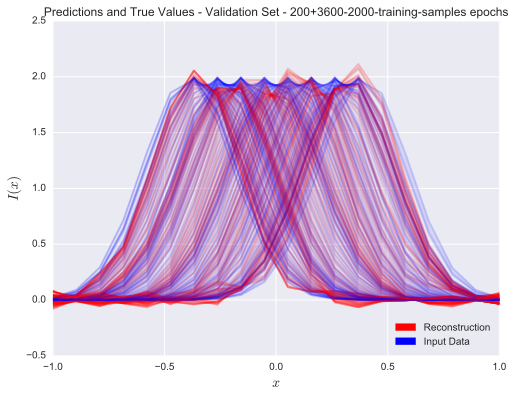

1395.25072789


In [31]:
jaeBaseline.predict_and_show(X_val, "200+3600-2000-training-samples")
print end - start

In [32]:
def chi2(x_val, rec):
    '''x_val: np.array(dims)
       rec: np.array(dims)
       Compute the chi^2 value corresponding to these inputs.'''
    return np.sum(np.square(rec - x_val))
    
    

In [33]:
## visualize the chi^2 for the predictions as a function of x_c

X_pred = jaeBaseline.predict(X_val)
chi2s = []
for i in range(len(xc_val)):
    chi2s.append(chi2(X_val[i], X_pred[i]))

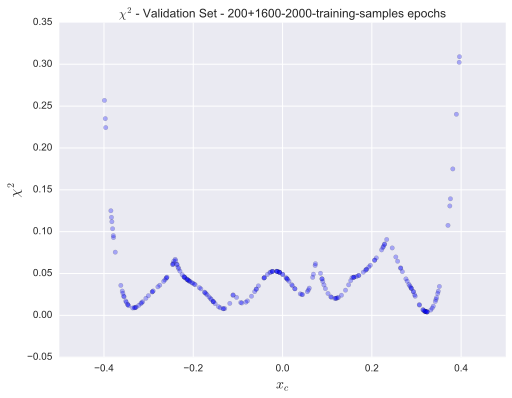

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
num_epoch = "200+1600-2000-training-samples"
f = plt.figure()
f.set_size_inches(8, 6)
plt.scatter(xc_val, chi2s, alpha = 0.3)
plt.xlabel(r"$x_c$", size = 14)
plt.ylabel(r"$\chi^2$", size = 14)
plt.title(r"$\chi^2$ - Validation Set - {} epochs".format(num_epoch))
plt.savefig("plots/chi2-{}-epochs.pdf".format(num_epoch))
plt.show()

In [11]:
def nCount(xc, xc_train, epsilon = 0.01):
    '''xc: floating point
       xc_train: numpy array (number of training samples)
       Count the number of values in xc_train within [xc - epsilon, xc + epsilon]'''
    count = 0
    for i in xc_train:
        if i > (xc - epsilon) and i < (xc + epsilon):
            count += 1
    return count

In [35]:
xc_inspect = np.arange(-0.4, 0.4, 0.02)
xc_train_counts = {i : nCount(i, xc_train, epsilon = 0.02) for i in xc_inspect}
chi2_xc = {}
# for i in xc_inspect:
#     xc_train_counts[i] = nCount(i, xc_train, epsilon = 0.02)

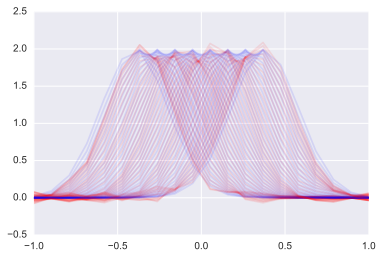

In [37]:
f = plt.figure()
x_space = np.linspace(-1, 1, 20)
for i in xc_inspect:
    val_sample = np.vstack((makePsf(np.linspace(-1, 1, 20), sigma1 = 0.2, xc = i), makePsf(x_space, sigma1 = 0.4, xc = i)))
    val_sample_pred = jaeBaseline.predict(val_sample)

    plt.plot(x_space, val_sample[0], color = 'b', alpha = 0.1)
    plt.plot(x_space, val_sample_pred[0], color = 'r', alpha = 0.1)
    chi2_sample =  chi2(val_sample[0], val_sample_pred[0])
    chi2_xc[i] = chi2_sample

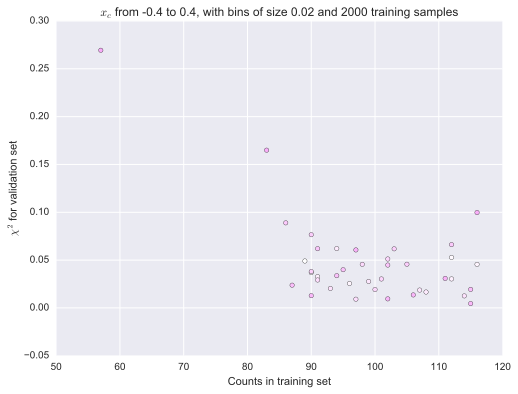

In [38]:

f = plt.figure()
f.set_size_inches(8, 6)
aCounts = np.array(xc_train_counts.values())
aChi2 = np.array(chi2_xc.values())
for k in xc_train_counts.keys():
    plt.scatter(xc_train_counts[k], chi2_xc[k], c = (np.exp(-np.abs(k)/15), np.exp(-np.abs(k)), np.exp(-np.abs(k)/15)))
plt.xlabel('Counts in training set')
plt.ylabel(r'$\chi^2$ for validation set')
plt.title(r'$x_c$ from -0.4 to 0.4, with bins of size 0.02 and 2000 training samples')
plt.savefig('plots/Counts-Chi2-200+400-epochs-2000-training-samples.pdf')
plt.show()

(223, 20)
